In [1]:
import numpy as np
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import xarray as xr
import xgcm
import gsw
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec

In [2]:
def fix_dimension(ds, bad_dim, new_dim, trim=True):
    assert len(ds[bad_dim]) == (len(ds[new_dim]) + 1)
    if trim and (len(ds[bad_dim]) == (len(ds[new_dim]) + 1)):
        ds = ds.isel(**{bad_dim: slice(0,-1)})
        assert len(ds[bad_dim]) == len(ds[new_dim])
    swapped_vars = []
    for v in ds:
        # replace naughty dimension
        dims = list(ds[v].dims)
        if bad_dim in dims:
            idx = dims.index(bad_dim)
            dims[idx] = new_dim
            ds[v].variable.dims = dims
            swapped_vars.append(v)
    return ds, swapped_vars

def reset_dimensions(ds, orig_dim, new_dim, *reset_vars):
    for v in reset_vars:
        dims = list(ds[v].dims)
        if new_dim in dims:
            idx = dims.index(new_dim)
            dims[idx] = orig_dim
            ds[v].variable.dims = dims
    # reindexing necessary to figure out new dims
    return ds.reindex()

def open_mncdataset(fname_base, ntiles_y, ntiles_x, iternum=None):
    if iternum is not None:
        itersuf = '.%010d' % iternum
    else:
        itersuf = ''
    dsets_y = []
    for ny in range(ntiles_y):
        dsets_x = []
        swap_vars = set()
        for nx in range(ntiles_x):
            ntile = nx + ntiles_x*ny + 1
            fname = fname_base + '%s.t%03d.nc' % (itersuf, ntile)
            ds = xr.open_dataset(fname)
            ds, swapped_vars_x = fix_dimension(ds, 'Xp1', 'X')    
            ds = ds.chunk()
            dsets_x.append(ds)
        ds_xconcat = xr.concat(dsets_x, 'X')
        ds_xconcat, swapped_vars_y = fix_dimension(ds_xconcat, 'Yp1', 'Y')
        dsets_y.append(ds_xconcat)
    ds = xr.concat(dsets_y, 'Y')
    ds = reset_dimensions(ds, 'Xp1', 'X', *swapped_vars_x)
    ds = reset_dimensions(ds, 'Yp1', 'Y', *swapped_vars_y)
    return ds



In [3]:
dss = open_mncdataset('run_bump_barotrop/state', 2, 3, 0)
dsg = open_mncdataset('run_bump_barotrop/grid', 2, 3, None)
dsbb=xr.merge((dss,dsg))
dsbb=dsbb.isel(Zp1=slice(0,-1))
dsbb=dsbb.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsbb = xgcm.generate_grid_ds(dsbb, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsbb.coords['day']=dsbb.T/(24*3600)

dss = open_mncdataset('run_bump_20layers/state', 2, 3, 0)
dsg = open_mncdataset('run_bump_20layers/grid', 2, 3, None)
dsb2=xr.merge((dss,dsg))
dsb2=dsb2.isel(Zp1=slice(0,-1))
dsb2=dsb2.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsb2 = xgcm.generate_grid_ds(dsb2, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsb2.coords['day']=dsb2.T/(24*3600)

dss = open_mncdataset('run_bump_tw/state', 2, 3, 0)
dsg = open_mncdataset('run_bump_tw/grid', 2, 3, None)
dsbt=xr.merge((dss,dsg))
dsbt=dsbt.isel(Zp1=slice(0,-1))
dsbt=dsbt.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsbt=xgcm.generate_grid_ds(dsbt, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsbt.coords['day']=dsbt.T/(24*3600)

dss = open_mncdataset('run_mr_barotrop/state', 2, 3, 0)
dsg = open_mncdataset('run_mr_barotrop/grid', 2, 3, None)
dsmb=xr.merge((dss,dsg))
dsmb=dsmb.isel(Zp1=slice(0,-1))
dsmb=dsmb.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsmb = xgcm.generate_grid_ds(dsmb, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsmb.coords['day']=dsmb.T/(24*3600)

dss = open_mncdataset('run_mr_20layers/state', 2, 3, 0)
dsg = open_mncdataset('run_mr_20layers/grid', 2, 3, None)
dsm2=xr.merge((dss,dsg))
dsm2=dsm2.isel(Zp1=slice(0,-1))
dsm2=dsm2.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsm2=xgcm.generate_grid_ds(dsm2, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsm2.coords['day']=dsm2.T/(24*3600)

dss = open_mncdataset('run_mr_tw/state', 2, 3, 0)
dsg = open_mncdataset('run_mr_tw/grid', 2, 3, None)
dsmt=xr.merge((dss,dsg))
dsmt=dsmt.isel(Zp1=slice(0,-1))
dsmt=dsmt.rename_dims({'Xp1':'X_left','Yp1':'Y_left','Zp1':'Z_left'})
dsmt=xgcm.generate_grid_ds(dsmt, {'X':'X', 'Y':'Y', 'Z':'Z'})
dsmt.coords['day']=dsmt.T/(24*3600)

In [4]:
dsbb['drU']=dsbb.U.isel(T=0)*0+dsbb.drF.isel(X=30,Y=20)
dsbb['drV']=dsbb.V.isel(T=0)*0+dsbb.drF.isel(X=30,Y=20)
metrics = {
    ('X',): ['dxC', 'dxG', 'dxV'], # X distances
    ('Y',): ['dyC', 'dyG', 'dyU'], # Y distances
    ('Z',): ['drC', 'drF', 'drU', 'drV'], # Z distances
    }
grid = xgcm.Grid(dsbb, periodic=False,metrics=metrics)

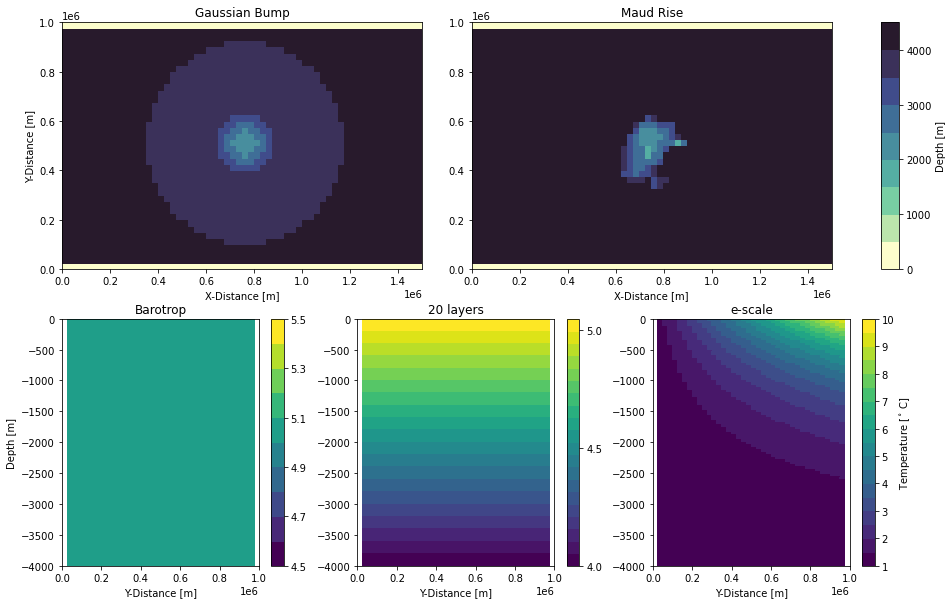

In [5]:
fig = plt.figure(figsize=(15,10))
gs = GridSpec(2,1, width_ratios=[1],wspace=.15)#,wspace=0.3)

gs1 = GridSpecFromSubplotSpec(1,3, subplot_spec=gs[0,0], width_ratios=[1,1,.05])
gs2 = GridSpecFromSubplotSpec(1,3, subplot_spec=gs[1,0], width_ratios=[1,1,1])

ax1 = fig.add_subplot(gs1[0])#,sharey=ttc_m12)
ax2 = fig.add_subplot(gs1[1])
cax_dep = fig.add_subplot(gs1[2])
ax3 = fig.add_subplot(gs2[0])#,sharey=ttc_m12)
ax4 = fig.add_subplot(gs2[1])
ax5 = fig.add_subplot(gs2[2])

# Plot used bathymetries
dsbb.Depth.plot.pcolormesh(vmin=0,vmax=4500,levels=10,ax=ax1,cmap=cmo.deep,add_colorbar=False)
cb_dep=dsmb.Depth.plot.pcolormesh(vmin=0,vmax=4500,levels=10,ax=ax2,cmap=cmo.deep,add_colorbar=False)
plt.colorbar(cb_dep,cax=cax_dep,label='Depth [m]', ticks=np.linspace(0,4000,5))
ax1.set_xlabel('X-Distance [m]')
ax1.set_ylabel('Y-Distance [m]')
ax1.set_title('Gaussian Bump')
ax2.set_xlabel('X-Distance [m]')
ax2.set_ylabel('')
ax2.set_title('Maud Rise')

# Plot used temperature stratification
dsbb.Temp.where(dsbb.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=4.5,vmax=5.5,levels=11,ax=ax3,cbar_kwargs={'label':''})#,add_colorbar=False)
dsb2.Temp.where(dsb2.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=4.,vmax=5.05,levels=21,ax=ax4,cbar_kwargs={'label':'','ticks':np.linspace(4,5,3)})#,add_colorbar=False)ax=ax4)#,add_colorbar=False)
dsbt.Temp.where(dsbt.Temp>0).isel(X=10,T=0).plot.pcolormesh(vmin=1,vmax=10,levels=19,ax=ax5,cbar_kwargs={'label':'Temperature [$^\circ\,$C]'})#,add_colorbar=False)
ax3.set_xlabel('Y-Distance [m]')
ax3.set_ylabel('Depth [m]')
ax3.set_title('Barotrop')
ax4.set_xlabel('Y-Distance [m]')
ax4.set_ylabel('')
ax4.set_title('20 layers')
ax5.set_xlabel('Y-Distance [m]')
ax5.set_ylabel('')
ax5.set_title('e-scale')
plt.savefig('./figures/set_up.png',dpi=300)

[Text(0, 0.0, ''),
 Text(0, 200000.0, ''),
 Text(0, 400000.0, ''),
 Text(0, 600000.0, ''),
 Text(0, 800000.0, ''),
 Text(0, 1000000.0, '')]

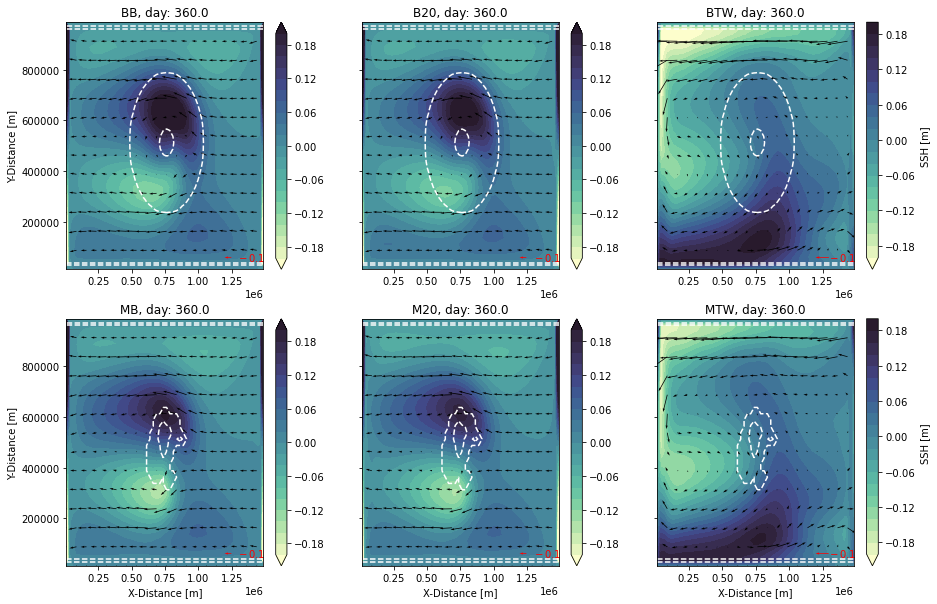

In [12]:
#plot SSH at last time step
t=12
arr=3
wmin=-.2
wmax=.2
cmap2=cmo.deep
lev=21

fig,axes=plt.subplots(2,3,figsize=(15,10))
ax=axes[0,0]
(dsbb.Eta.isel(T=t)-dsbb.Eta.isel(T=-1,X=58)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsbb.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsbb.X[0:-1:arr],dsbb.Y[0:-1:arr],grid.interp(dsbb.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbb.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'BB, day: {dsbb.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('Y-Distance [m]')
ax=axes[0,1]
(dsb2.Eta.isel(T=t)-dsb2.Eta.isel(T=-1,X=58)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsb2.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsb2.X[0:-1:arr],dsb2.Y[0:-1:arr],grid.interp(dsb2.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsb2.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'B20, day: {dsb2.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax=axes[0,2]
(dsbt.Eta.isel(T=t)-dsbt.Eta.isel(T=-1,X=58)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':'SSH [m]'})
dsbt.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsbt.X[0:-1:arr],dsbt.Y[0:-1:arr],grid.interp(dsbt.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbt.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'BTW, day: {dsbt.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')

ax=axes[1,0]
(dsmb.Eta.isel(T=t)-dsmb.Eta.isel(T=-1,X=58)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsmb.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsmb.X[0:-1:arr],dsmb.Y[0:-1:arr],grid.interp(dsmb.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsmb.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'MB, day: {dsmb.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Y-Distance [m]')
ax=axes[1,1]
(dsm2.Eta.isel(T=t)-dsm2.Eta.isel(T=-1,X=58)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsm2.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsm2.X[0:-1:arr],dsm2.Y[0:-1:arr],grid.interp(dsm2.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsm2.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'M20, day: {dsm2.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')
ax=axes[1,2]
(dsmt.Eta.isel(T=t)-dsmt.Eta.isel(T=-1,X=58)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':'SSH [m]'})
dsmt.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsmt.X[0:-1:arr],dsmt.Y[0:-1:arr],grid.interp(dsmt.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsmt.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'MTW, day: {dsmt.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')

In [7]:
# compute streamfunctions for all along U since the boundaries are closed
dsbb['psi'] = grid.cumint(-grid.integrate(dsbb.U,'Z'),'Y', boundary='fill')/1e6
dsb2['psi'] = grid.cumint(-grid.integrate(dsb2.U,'Z'),'Y', boundary='fill')/1e6
dsbt['psi'] = grid.cumint(-grid.integrate(dsbt.U,'Z'),'Y', boundary='fill')/1e6

dsmb['psi'] = grid.cumint(-grid.integrate(dsmb.U,'Z'),'Y', boundary='fill')/1e6
dsm2['psi'] = grid.cumint(-grid.integrate(dsm2.U,'Z'),'Y', boundary='fill')/1e6
dsmt['psi'] = grid.cumint(-grid.integrate(dsmt.U,'Z'),'Y', boundary='fill')/1e6

# relative vorticity
dsbb['ze']=-1*grid.derivative(dsbb.U,'Y',boundary='extend')+(grid.derivative(dsbb.V,'X',boundary='extend'))
dsb2['ze']=-1*grid.derivative(dsb2.U,'Y',boundary='extend')+(grid.derivative(dsb2.V,'X',boundary='extend'))
dsbt['ze']=-1*grid.derivative(dsbt.U,'Y',boundary='extend')+(grid.derivative(dsbt.V,'X',boundary='extend'))

dsmb['ze']=-1*grid.derivative(dsmb.U,'Y',boundary='extend')+(grid.derivative(dsmb.V,'X',boundary='extend'))
dsm2['ze']=-1*grid.derivative(dsm2.U,'Y',boundary='extend')+(grid.derivative(dsm2.V,'X',boundary='extend'))
dsmt['ze']=-1*grid.derivative(dsmt.U,'Y',boundary='extend')+(grid.derivative(dsmt.V,'X',boundary='extend'))

[Text(0, 0.0, ''),
 Text(0, 200000.0, ''),
 Text(0, 400000.0, ''),
 Text(0, 600000.0, ''),
 Text(0, 800000.0, ''),
 Text(0, 1000000.0, '')]

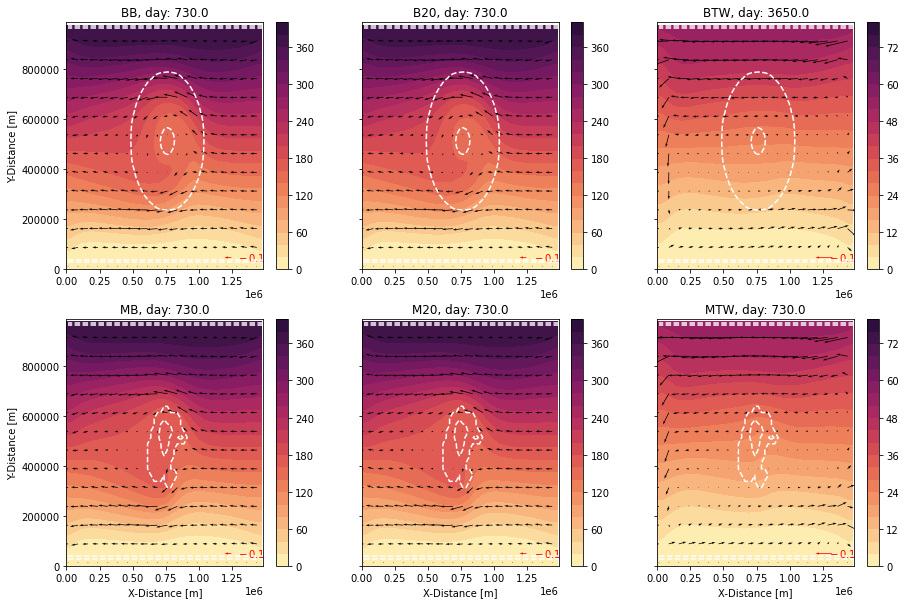

In [8]:
#plot streamfunction at last time step
wmin=0
wmax=400
lev=21
t=-1
cmap2=cmo.matter
fig,axes=plt.subplots(2,3,figsize=(15,10))
ax=axes[0,0]
dsbb.psi.isel(T=t).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsbb.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsbb.X[0:-1:arr],dsbb.Y[0:-1:arr],grid.interp(dsbb.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbb.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'BB, day: {dsbb.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('Y-Distance [m]')
ax=axes[0,1]
(dsb2.psi.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsb2.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsb2.X[0:-1:arr],dsb2.Y[0:-1:arr],grid.interp(dsb2.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsb2.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'B20, day: {dsb2.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax=axes[0,2]
(dsbt.psi.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax*.2,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsbt.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsbt.X[0:-1:arr],dsbt.Y[0:-1:arr],grid.interp(dsbt.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbt.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'BTW, day: {dsbt.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')


ax=axes[1,0]
(dsmb.psi.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsmb.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsmb.X[0:-1:arr],dsmb.Y[0:-1:arr],grid.interp(dsmb.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsmb.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'MB, day: {dsmb.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Y-Distance [m]')
ax=axes[1,1]
(dsm2.psi.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsm2.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsm2.X[0:-1:arr],dsm2.Y[0:-1:arr],grid.interp(dsm2.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsm2.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'M20, day: {dsm2.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')
ax=axes[1,2]
(dsmt.psi.isel(T=t)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax*.2,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsmt.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsmt.X[0:-1:arr],dsmt.Y[0:-1:arr],grid.interp(dsmt.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsmt.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'MTW, day: {dsmt.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')

[Text(0, 0.0, ''),
 Text(0, 200000.0, ''),
 Text(0, 400000.0, ''),
 Text(0, 600000.0, ''),
 Text(0, 800000.0, ''),
 Text(0, 1000000.0, '')]

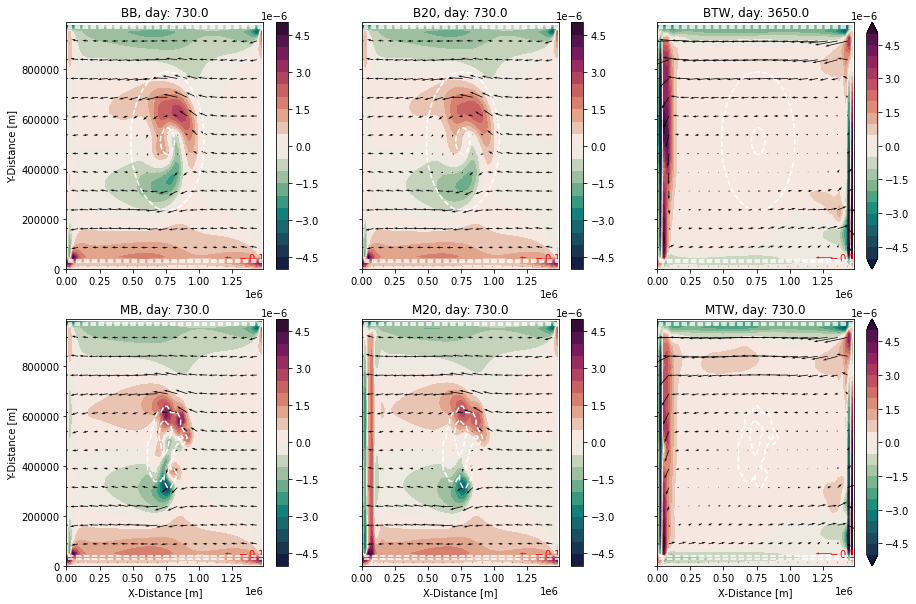

In [9]:
#plot surface relative vorticity at last time step
wmin=-5e-6
wmax=-1*wmin
lev=21
cmap2=cmo.curl
t=-1
zz=0
fig,axes=plt.subplots(2,3,figsize=(15,10))
ax=axes[0,0]
dsbb.ze.isel(T=t,Z=zz).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsbb.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsbb.X[0:-1:arr],dsbb.Y[0:-1:arr],grid.interp(dsbb.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbb.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'BB, day: {dsbb.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('Y-Distance [m]')
ax=axes[0,1]
(dsb2.ze.isel(T=t,Z=zz)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsb2.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsb2.X[0:-1:arr],dsb2.Y[0:-1:arr],grid.interp(dsb2.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsb2.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'B20, day: {dsb2.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax=axes[0,2]
(dsbt.ze.isel(T=t,Z=zz)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsbt.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsbt.X[0:-1:arr],dsbt.Y[0:-1:arr],grid.interp(dsbt.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbt.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'BTW, day: {dsbt.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')


ax=axes[1,0]
(dsmb.ze.isel(T=t,Z=zz)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsmb.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsmb.X[0:-1:arr],dsmb.Y[0:-1:arr],grid.interp(dsmb.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsmb.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'MB, day: {dsmb.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Y-Distance [m]')
ax=axes[1,1]
(dsm2.ze.isel(T=t,Z=zz)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsm2.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsm2.X[0:-1:arr],dsm2.Y[0:-1:arr],grid.interp(dsm2.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsm2.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'M20, day: {dsm2.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')
ax=axes[1,2]
(dsmt.ze.isel(T=t,Z=zz)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsmt.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsmt.X[0:-1:arr],dsmt.Y[0:-1:arr],grid.interp(dsmt.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsmt.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'MTW, day: {dsmt.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')

[Text(0, 0.0, ''),
 Text(0, 200000.0, ''),
 Text(0, 400000.0, ''),
 Text(0, 600000.0, ''),
 Text(0, 800000.0, ''),
 Text(0, 1000000.0, '')]

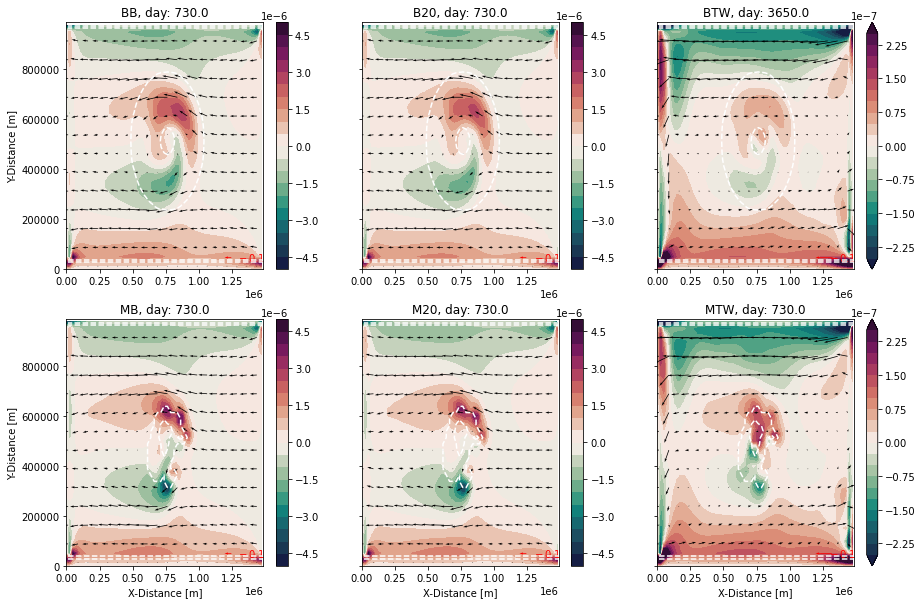

In [10]:
#plot depth mean relative vorticity at last time step
wmin=-5e-6
wmax=-1*wmin
lev=21
cmap2=cmo.curl
t=-1
zz=0
fig,axes=plt.subplots(2,3,figsize=(15,10))
ax=axes[0,0]
dsbb.ze.isel(T=t).mean(dim='Z').plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsbb.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsbb.X[0:-1:arr],dsbb.Y[0:-1:arr],grid.interp(dsbb.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbb.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'BB, day: {dsbb.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('Y-Distance [m]')
ax=axes[0,1]
dsb2.ze.isel(T=t).mean(dim='Z').plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsb2.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsb2.X[0:-1:arr],dsb2.Y[0:-1:arr],grid.interp(dsb2.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsb2.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'B20, day: {dsb2.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax=axes[0,2]
dsbt.ze.isel(T=t).mean(dim='Z').plot.contourf(cmap=cmap2,vmin=wmin*0.05,vmax=wmax*0.05,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsbt.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsbt.X[0:-1:arr],dsbt.Y[0:-1:arr],grid.interp(dsbt.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsbt.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'BTW, day: {dsbt.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')


ax=axes[1,0]
dsmb.ze.isel(T=t).mean(dim='Z').plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsmb.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsmb.X[0:-1:arr],dsmb.Y[0:-1:arr],grid.interp(dsmb.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsmb.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'MB, day: {dsmb.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('Y-Distance [m]')
ax=axes[1,1]
dsm2.ze.isel(T=t).mean(dim='Z').plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsm2.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsm2.X[0:-1:arr],dsm2.Y[0:-1:arr],grid.interp(dsm2.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsm2.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'M20, day: {dsm2.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')
ax=axes[1,2]
dsmt.ze.isel(T=t).mean(dim='Z').plot.contourf(cmap=cmap2,vmin=wmin*0.05,vmax=wmax*0.05,levels=lev,ax=ax,cbar_kwargs={'label':''})
dsmt.Depth.plot.contour(levels=[2500,3999],ax=ax,linestyles='--',colors='w')
q=ax.quiver(dsmt.X[0:-1:arr],dsmt.Y[0:-1:arr],grid.interp(dsmt.isel(T=t,Z=0).U,'X',boundary='extend')[0:-1:arr,0:-1:arr],grid.interp(dsmt.isel(T=t,Z=0).V,'Y',boundary='extend')[0:-1:arr,0:-1:arr])
ax.quiverkey(q,0.8,0.05,-0.1,label='$-\,0.1$',color='r',labelpos='E',labelcolor='r',labelsep=0.2)
ax.set_title(f'MTW, day: {dsmt.day.isel(T=t).values}')
ax.set_xlabel('X-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')

Text(0, 0.5, '')

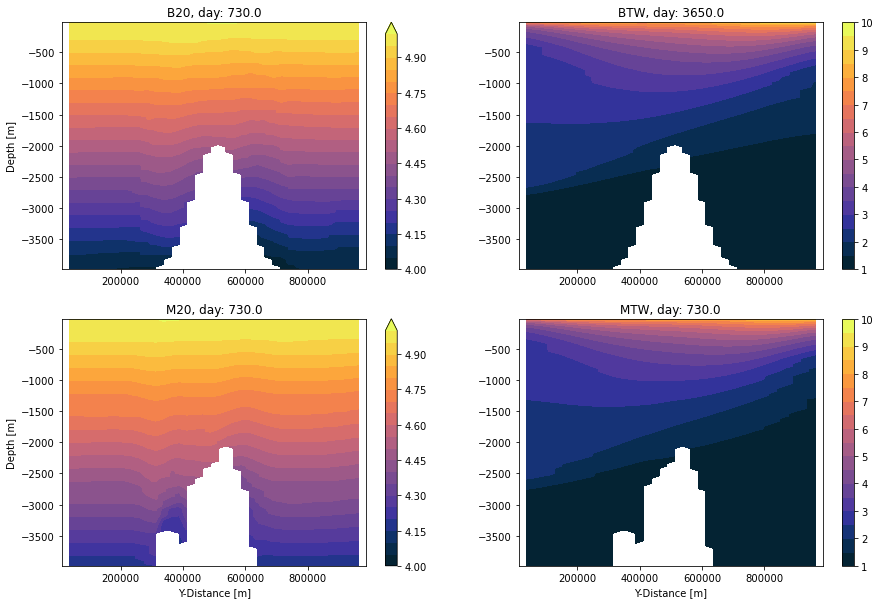

In [11]:
#plot T Section at last time step
wmax=5
wmin=4
lev=21
wmaxt=10
wmint=1
levt=19
cmap2=cmo.thermal
t=-1
fig,axes=plt.subplots(2,2,figsize=(15,10))
ax=axes[0,0]
(dsb2.Temp.where(dsb2.Temp>0).isel(T=t,X=30)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.set_title(f'B20, day: {dsb2.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('Depth [m]')

ax=axes[0,1]
(dsbt.Temp.where(dsbt.Temp>0).isel(T=t,X=30)).plot.contourf(cmap=cmap2,vmin=wmint,vmax=wmaxt,levels=levt,ax=ax,cbar_kwargs={'label':''})
ax.set_title(f'BTW, day: {dsbt.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')

ax=axes[1,0]
(dsm2.Temp.where(dsm2.Temp>0).isel(T=t,X=30)).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.set_title(f'M20, day: {dsm2.day.isel(T=t).values}')
ax.set_xlabel('Y-Distance [m]')
ax.set_ylabel('Depth [m]')
ax=axes[1,1]
(dsmt.Temp.where(dsmt.Temp>0).isel(T=t,X=30)).plot.contourf(cmap=cmap2,vmin=wmint,vmax=wmaxt,levels=levt,ax=ax,cbar_kwargs={'label':''})

ax.set_title(f'MTW, day: {dsmt.day.isel(T=t).values}')
ax.set_xlabel('Y-Distance [m]')
ax.set_ylabel('')

[Text(0, -4000.0, ''),
 Text(0, -3500.0, ''),
 Text(0, -3000.0, ''),
 Text(0, -2500.0, ''),
 Text(0, -2000.0, ''),
 Text(0, -1500.0, ''),
 Text(0, -1000.0, ''),
 Text(0, -500.0, ''),
 Text(0, 0.0, '')]

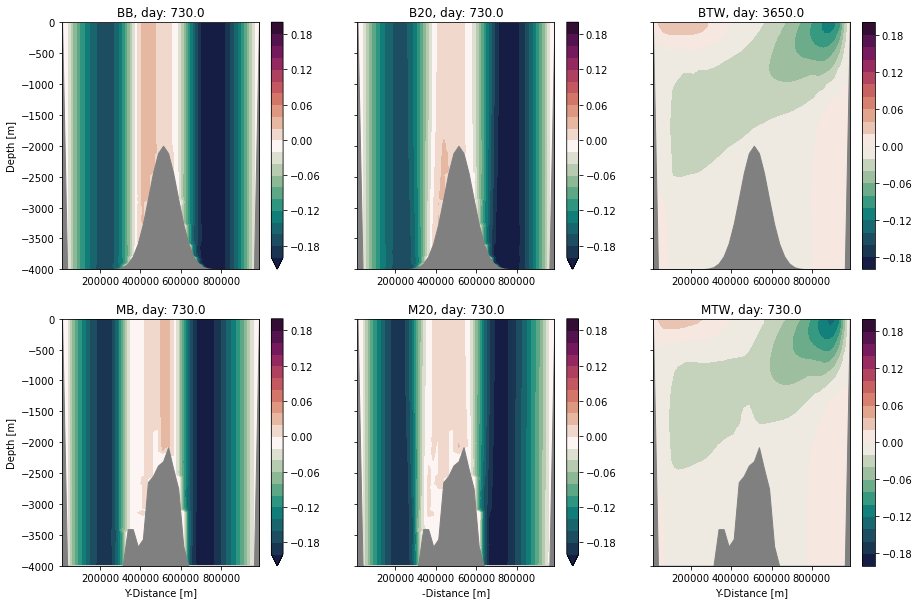

In [12]:
#plot relative vorticity at last time step
wmin=-.2
wmax=.2
lev=21
cmap2=cmo.curl
t=-1
xx=30
fig,axes=plt.subplots(2,3,figsize=(15,10))
ax=axes[0,0]
dsbb.U.isel(T=t,X_left=xx).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(dsbb.Y,(-1*dsbb.Depth).isel(X=30),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'BB, day: {dsbb.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('Depth [m]')
ax=axes[0,1]
dsb2.U.isel(T=t,X_left=xx).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(dsb2.Y,(-1*dsb2.Depth).isel(X=30),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'B20, day: {dsb2.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax=axes[0,2]
dsbt.U.isel(T=t,X_left=xx).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(dsbt.Y,(-1*dsbt.Depth).isel(X=30),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'BTW, day: {dsbt.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')


ax=axes[1,0]
dsmb.U.isel(T=t,X_left=xx).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(dsmb.Y,(-1*dsmb.Depth).isel(X=30),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'MB, day: {dsmb.day.isel(T=t).values}')
ax.set_xlabel('Y-Distance [m]')
ax.set_ylabel('Depth [m]')
ax=axes[1,1]
dsm2.U.isel(T=t,X_left=xx).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(dsm2.Y,(-1*dsm2.Depth).isel(X=30),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'M20, day: {dsm2.day.isel(T=t).values}')
ax.set_xlabel('-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')
ax=axes[1,2]
dsmt.U.isel(T=t,X_left=xx).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(dsmt.Y,(-1*dsmt.Depth).isel(X=30),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'MTW, day: {dsmt.day.isel(T=t).values}')
ax.set_xlabel('Y-Distance [m]')

ax.set_ylabel('')
ax.set_yticklabels('')

[Text(0, -4000.0, ''),
 Text(0, -3500.0, ''),
 Text(0, -3000.0, ''),
 Text(0, -2500.0, ''),
 Text(0, -2000.0, ''),
 Text(0, -1500.0, ''),
 Text(0, -1000.0, ''),
 Text(0, -500.0, ''),
 Text(0, 0.0, '')]

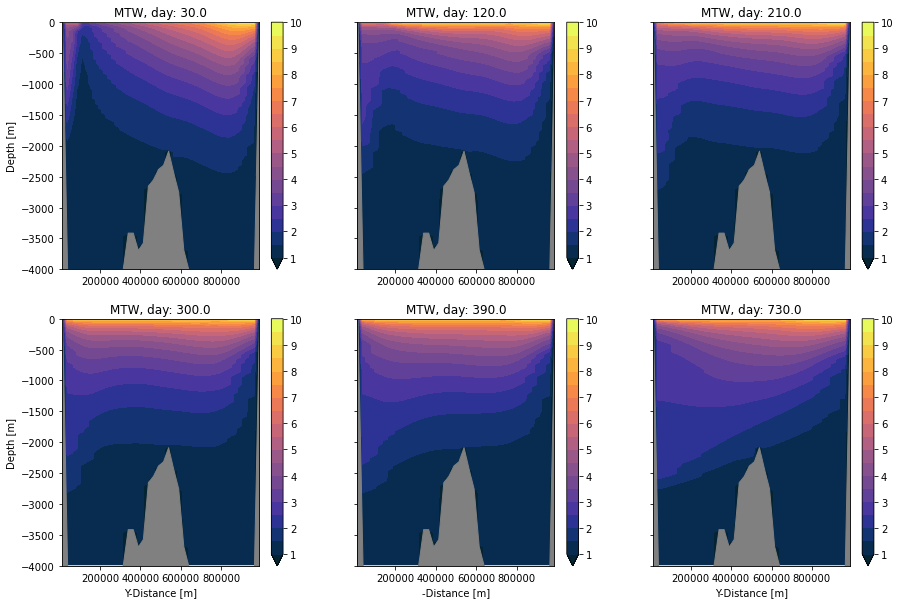

In [13]:
#plot relative vorticity at last time step
wmax=10
wmin=1
lev=19
cmap2=cmo.thermal
t=-1
xx=30
fig,axes=plt.subplots(2,3,figsize=(15,10))
ax=axes[0,0]
t=1
dsmt.Temp.isel(T=t,X=xx).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(dsmt.Y,(-1*dsmt.Depth).isel(X=30),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'MTW, day: {dsmt.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('Depth [m]')
ax=axes[0,1]
t=4
dsmt.Temp.isel(T=t,X=xx).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(dsmt.Y,(-1*dsmt.Depth).isel(X=30),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'MTW, day: {dsmt.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')
ax=axes[0,2]
t=7
dsmt.Temp.isel(T=t,X=xx).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(dsmt.Y,(-1*dsmt.Depth).isel(X=30),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'MTW, day: {dsmt.day.isel(T=t).values}')
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_yticklabels('')


ax=axes[1,0]
t=10
dsmt.Temp.isel(T=t,X=xx).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(dsmt.Y,(-1*dsmt.Depth).isel(X=30),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'MTW, day: {dsmt.day.isel(T=t).values}')
ax.set_xlabel('Y-Distance [m]')
ax.set_ylabel('Depth [m]')
ax=axes[1,1]
t=13
dsmt.Temp.isel(T=t,X=xx).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(dsmt.Y,(-1*dsmt.Depth).isel(X=30),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'MTW, day: {dsmt.day.isel(T=t).values}')
ax.set_xlabel('-Distance [m]')
ax.set_ylabel('')
ax.set_yticklabels('')
ax=axes[1,2]
t=-1
dsmt.Temp.isel(T=t,X=xx).plot.contourf(cmap=cmap2,vmin=wmin,vmax=wmax,levels=lev,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(dsmt.Y,(-1*dsmt.Depth).isel(X=30),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'MTW, day: {dsmt.day.isel(T=t).values}')
ax.set_xlabel('Y-Distance [m]')

ax.set_ylabel('')
ax.set_yticklabels('')

Text(0.5, 0, 'Y-Distance [m]')

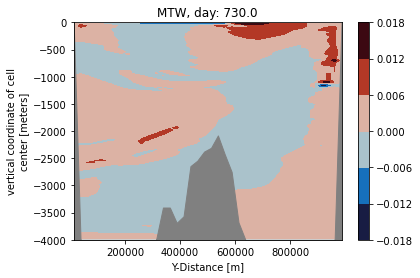

In [177]:
fig,axes=plt.subplots(1,1)
ax=axes
(dsmt.Temp.isel(T=t,X=xx)-dsmt.Temp.isel(T=-2,X=xx)).plot.contourf(cmap=cmo.balance,ax=ax,cbar_kwargs={'label':''})
ax.fill_between(dsmt.Y,(-1*dsmt.Depth).isel(X=30),-4000,color='grey')
ax.set_ylim(-4000,0)
ax.set_title(f'MTW, day: {dsmt.day.isel(T=t).values}')
ax.set_xlabel('Y-Distance [m]')

In [179]:
dsmt.ze

<xarray.DataArray 'ze' (T: 26, Z: 100, Y_left: 40, X_left: 60)>
dask.array<add, shape=(26, 100, 40, 60), dtype=float64, chunksize=(26, 100, 19, 19), chunktype=numpy.ndarray>
Coordinates:
    Yp1      (Y_left) float64 0.0 2.5e+04 5e+04 ... 9.25e+05 9.5e+05 9.75e+05
    Xp1      (X_left) float64 0.0 2.5e+04 5e+04 ... 1.425e+06 1.45e+06 1.475e+06
  * T        (T) float64 0.0 2.592e+06 5.184e+06 ... 6.221e+07 6.307e+07
  * Z        (Z) float64 -20.0 -60.0 -100.0 ... -3.9e+03 -3.94e+03 -3.98e+03
  * X_left   (X_left) float64 0.0 2.5e+04 5e+04 ... 1.425e+06 1.45e+06 1.475e+06
  * Y_left   (Y_left) float64 0.0 2.5e+04 5e+04 ... 9.25e+05 9.5e+05 9.75e+05
    day      (T) float64 0.0 30.0 60.0 90.0 120.0 ... 660.0 690.0 720.0 730.0

In [155]:
ax.fill_between(dsbb.Y,(-1*dsbb.Depth).isel(X=30),-4000)